In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%reload_ext autoreload

In [9]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/mnt/antares_raid/home/bramantyos/codes/multilang_timescale


In [13]:
import numpy as np
import pandas as pd

import cortex

import matplotlib.pyplot as plt
import seaborn as sns

from src.trainer import Trainer
from src.settings import ResultSetting

from src.utils import put_values_on_mask
from src.utils import read_result_meta, get_surface_dict, delete_empty_result

from src.configurations import timescale_ranges, timescales

from voxelwise_tutorials.io import load_hdf5_sparse_array

In [11]:
from src.configurations import config_plotting

config_plotting("paper")

In [12]:
surfaces_json = ".temp/fmri/bling/surfaces.json"
surfaces_dir = "/mnt/raid/bling/share/pycortex_store"

mapper_dir = "/mnt/raid/bling/share/mappers"

result_metric = "r2"
result_meta_dir = ".temp/result_meta/bling"

subjects_ids = ["COL", "GFW", "TYE"]

alpha = 0.05
alpha_pred_acc = None

In [31]:
timescale_data = []

for subject_id in subjects_ids:
    surface_dict = get_surface_dict(subject_id)

    subject_file_en = f".temp/config/bling/subject/{subject_id}_en.json"
    subject_file_zh = f".temp/config/bling/subject/{subject_id}_zh.json"

    trainer_en_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_en_timescale.json"
    )
    trainer_zh_file = (
        f".temp/config/bling/train/stepwise/{subject_id.lower()}_zh_timescale.json"
    )

    feature_file_en = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_en.json"
    feature_file_zh = f".temp/config/bling/feature/{subject_id}/mBERT_all_untrimmed_timescale_stepwise_zh.json"

    mapper_file = os.path.join(mapper_dir, f"{subject_id}_fsaverage_mapper.hdf")

    en_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_en_file,
        subject_setting_path=subject_file_en,
        feature_setting_path=feature_file_en,
    )
    zh_meta_df = read_result_meta(
        result_meta_dir,
        trainer_setting_path=trainer_zh_file,
        subject_setting_path=subject_file_zh,
        feature_setting_path=feature_file_zh,
    )

    en_config = en_meta_df.iloc[0].to_dict()
    zh_config = zh_meta_df.iloc[0].to_dict()

    en_stats = np.load(en_config["stats_path"])
    zh_stats = np.load(zh_config["stats_path"])

    keyword = f"test_{result_metric}_score_mask"
    p_val_keyword = f"test_p_values_{result_metric}_mask"

    en_timescales = en_stats[keyword]
    zh_timescales = zh_stats[keyword]

    for i in range(8):
        timescale_en = en_timescales[i]
        timescale_zh = zh_timescales[i]

        if result_metric == "r2":
            timescale_en = np.sqrt(timescale_en)
            timescale_zh = np.sqrt(timescale_zh)

        timescale_en, _ = put_values_on_mask(
            timescale_en,
            en_stats[p_val_keyword],
            ev_mask=None,
            alpha=alpha,
            valid_range=(0, 1),
        )

        timescale_zh, _ = put_values_on_mask(
            timescale_zh,
            zh_stats[p_val_keyword],
            ev_mask=None,
            alpha=alpha,
            valid_range=(0, 1),
        )

        timescale_en = np.nan_to_num(timescale_en)
        timescale_zh = np.nan_to_num(timescale_zh)

        # project to fsaverage
        mapper = load_hdf5_sparse_array(mapper_file, key="voxel_to_fsaverage")

        projected_en = timescale_en @ mapper.T
        projected_zh = timescale_zh @ mapper.T

        # drop nan
        timescale_data.append(
            {
                "subject_id": subject_id,
                "language": "en",
                "timescale": timescales[i],
                "data": projected_en,
            }
        )

        timescale_data.append(
            {
                "subject_id": subject_id, 
                "language": "zh", 
                "timescale": timescales[i],
                "data": projected_zh
            }
        )

/tmp/ipykernel_2842294/1615859778.py:51: RuntimeWarning: invalid value encountered in sqrt
  timescale_en = np.sqrt(timescale_en)
/tmp/ipykernel_2842294/1615859778.py:52: RuntimeWarning: invalid value encountered in sqrt
  timescale_zh = np.sqrt(timescale_zh)
/tmp/ipykernel_2842294/1615859778.py:51: RuntimeWarning: invalid value encountered in sqrt
  timescale_en = np.sqrt(timescale_en)
/tmp/ipykernel_2842294/1615859778.py:52: RuntimeWarning: invalid value encountered in sqrt
  timescale_zh = np.sqrt(timescale_zh)
/tmp/ipykernel_2842294/1615859778.py:51: RuntimeWarning: invalid value encountered in sqrt
  timescale_en = np.sqrt(timescale_en)
/tmp/ipykernel_2842294/1615859778.py:52: RuntimeWarning: invalid value encountered in sqrt
  timescale_zh = np.sqrt(timescale_zh)


In [32]:
# # iterate over subjects and timescales range
# timescales = []
# for subject_id in subjects_ids:
#     for k in timescale_ranges.keys():
#         range = timescale_ranges[k]

#         cur_en_timescale = timescale_data[subject_id]["en"]
#         cur_zh_timescale = timescale_data[subject_id]["zh"]

#         # if values are not withing range, set to zero, otherwise keep the value
#         cur_en_timescale = (cur_en_timescale >= range[0]) & (cur_en_timescale <= range[1]).astype(int)
            
#         cur_zh_timescale = (cur_zh_timescale >= range[0]) & (cur_zh_timescale <= range[1]).astype(int)
            
#         timescales.append({
#             "subject_id": subject_id,
#             "timescale": k,
#             "language": "en",
#             "data": cur_en_timescale,
#         })
        
#         timescales.append({
#             "subject_id": subject_id,
#             "timescale": k,
#             "language": "zh",
#             "data": cur_zh_timescale,
#         })

In [33]:
timescales_df = pd.DataFrame(timescale_data)
timescales_df.sort_values(["subject_id", "language"], inplace=True,)
timescales_df.reset_index(drop=True, inplace=True)

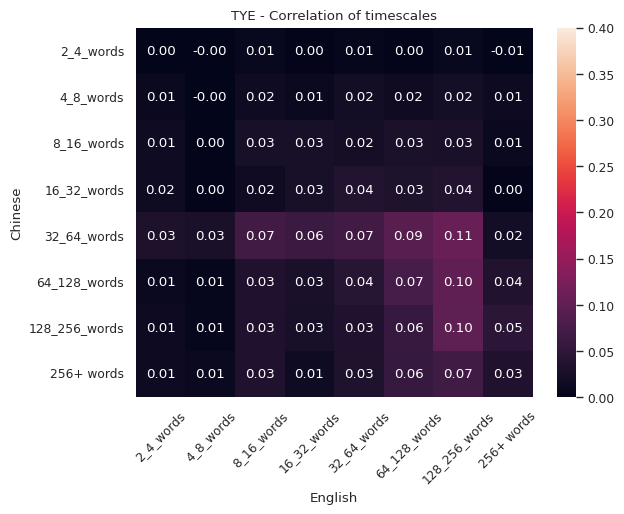

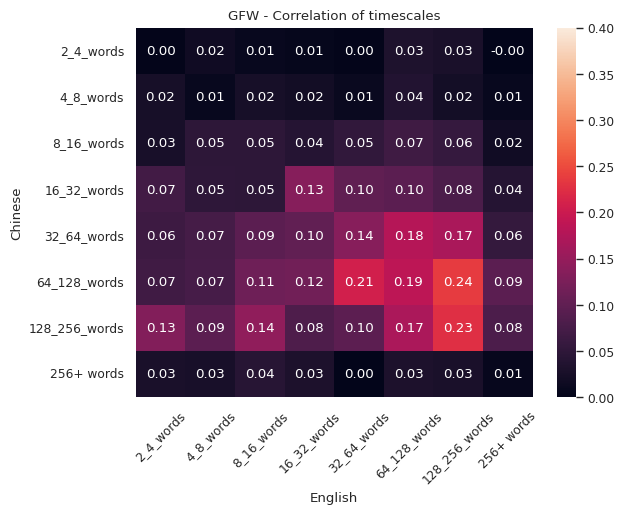

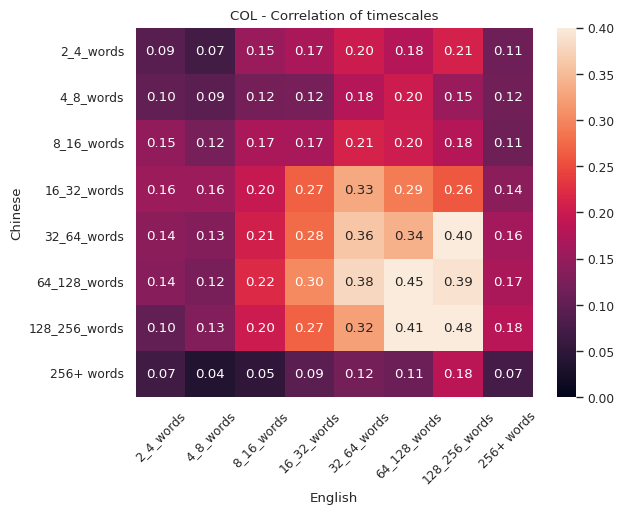

In [36]:
# plot heatmap for each subjects
corr_avg = np.zeros((16, 16))
for subject_id in ['TYE', 'GFW', 'COL']:
    col_df = timescales_df[timescales_df["subject_id"] == subject_id]
    col_df = col_df.sort_values(by=["language"])
    col_df.reset_index(drop=True, inplace=True)
    
    data = np.vstack(col_df["data"].values)

    # compute correlation
    corr = np.corrcoef(data)
    corr_avg += corr
    sns.heatmap(
        corr[8:,:8],
        annot=True,
        xticklabels=timescales_df["timescale"].unique(),
        yticklabels=timescales_df["timescale"].unique(),
        fmt=".2f",
        vmin=0,
        vmax=0.4
    )

    plt.ylabel("Chinese")
    plt.xlabel("English")
    plt.title(subject_id)
    plt.xticks(rotation=45)
    plt.title(f"{subject_id} - Correlation of timescales")
    plt.show()

In [39]:
corr_avg

(16, 16)

Text(0.5, 1.0, 'Average - Correlation of timescales')

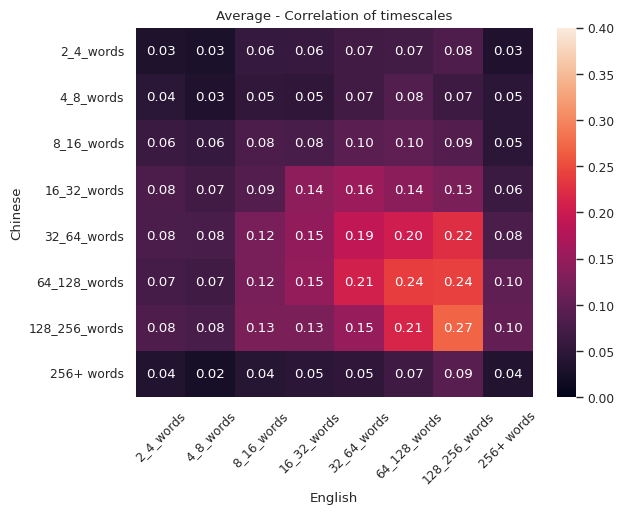

In [37]:
# plot corr_avg 
corr_avg /= len(subjects_ids)

sns.heatmap(
    corr_avg[8:,:8],
    annot=True,
    xticklabels=timescales_df["timescale"].unique(),
    yticklabels=timescales_df["timescale"].unique(),
    fmt=".2f",
    vmin=0,
    vmax=0.4
)

plt.ylabel("Chinese")
plt.xlabel("English")

plt.xticks(rotation=45)
plt.title("Average - Correlation of timescales")
